In [1]:
import numpy as np
import pandas as pd
import plot_util
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from scipy.stats import linregress, gmean

plt.style.use('style.mpl')

In [2]:
# Read in a combined dataframe of all the coding sequence NOSC values.
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')

# Amino acid properties
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Reading the monte-carlo samples of proteome NOSC per-genome.
# These are "weighted" i.e. allowing for 5 order of variation in expression.
weighted_nosc_est_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC_weighted_monte_carlo_samples.csv')

# Single files per-organism of proteome level Z_C at different growth rates.
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
yeast_data = pd.read_csv('../data/proteomes/Scer/Xia_proteome_NOSC.csv')
cyano_data = pd.read_csv('../data/proteomes/Synechocystis/Zavrel_proteome_NOSC.csv')

# Unified file of the protein-level measurements.
all_expression_data = pd.read_csv('../data/proteomes/all_protein_measurements.csv')

# Kayser et al has specific O2 consumption rates for E. coli in a chemostat
# TODO: preprocess to convert units so we don't need to do it here. 
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Postma et al has specific O2 consumption rates for Yeast in a chemostat
postma_chemostat_df = pd.read_csv('../data/chemostat_data/postma_chemostat_growth_unit_conv.csv')

# Estimated mmol protein C per gram dry weight in a separate notebook
# Estimate is based on E. coli data, would be a bit different for yeast.
mmol_prot_C_per_gDW_est_df = pd.read_csv('../data/proteomes/Coli/mmol_protC_per_gDW_est.csv', index_col=0)

# Fits of the growth dependence of respiratory NADH consumption.
fit_resp_NADH_consumption_df = pd.read_csv('../data/chemostat_data/respiratory_NADH_consumption_fits.csv', index_col=0)

/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
coli_data.head()

,dataset,strain,condition,growth_rate_hr,Ce_total,NC_total,proteome_NOSC
0,li_2014,MG1655,MOPS complete,1.934364,-2.873416e+09,1.979388e+10,-0.145167
1,li_2014,MG1655,MOPS complete without methionine,1.569390,-2.085635e+09,1.456026e+10,-0.143242
2,li_2014,MG1655,MOPS minimal,0.738700,-1.020722e+09,7.199098e+09,-0.141785
3,peebo_2015,BW25113,glucose_minimal,0.210000,-6.324929e+08,4.438966e+09,-0.142487
4,peebo_2015,BW25113,glucose_minimal,0.220000,-6.374814e+08,4.479156e+09,-0.142322


In [4]:
kayser_chemostat_df.head()

,D_per_h,biomass_g_l,glucose_g_l,acetate_g_l,ammonium_g_l,CTR,OTR,c_recovery_pct,n_recovery_pct,r_biomass_g_l_h,r_glucose_g_g_h,r_co2_g_g_h,r_o2_g_g_h,r_acetate_g_g_h,r_ammonium_g_g_h,r_o2_mmol_g_h,r_o2_mmol_NADH_g_h
0,0.044,5.07,0.0,0.0,1.709,0.286,0.222,96,99,0.223,0.087,0.056,0.0437,0.0 000,0.0060,1.365625,2.73125
1,0.066,5.05,0.0,0.0,1.688,0.440,0.288,97,98,0.333,0.131,0.087,0.0570,0.0 000,0.0093,1.781250,3.56250
2,0.134,5.29,0.0,0.0,1.652,0.924,0.576,101,98,0.709,0.253,0.175,0.1089,0.0 000,0.0190,3.403125,6.80625
3,0.150,5.24,0.0,0.0,1.650,0.915,0.615,95,98,0.785,0.287,0.175,0.1175,0.0 000,0.0215,3.671875,7.34375
4,0.170,5.23,0.0,0.0,1.656,1.113,0.896,98,98,0.889,0.325,0.213,0.1713,0.0 000,0.0242,5.353125,10.70625


In [5]:
mask = coli_data.condition == 'glucose_minimal'
mask = np.logical_or(mask, coli_data.condition.str.startswith('chemostat'))
coli_chemostat = coli_data[mask].copy()

# Extract the ribosome profiling data
mask = coli_data.dataset == 'li_2014'
coli_li = coli_data[mask].copy()

# extract schmidt 2016 data in chemostat_conds
coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_u')]

# extract schmidt 2016 minimal media non-stress conds
mm_conds = 'glucose,fructose,galactose,glucosamine,xylose,mannose,glycerol,succinate,fumarate,pyruvate,acetate'.split(',')
mask = np.logical_and(coli_data.condition.isin(mm_conds), 
                      coli_data.dataset == 'schmidt_2016')
coli_schmidt_batch = coli_data[mask].copy()

/var/folders/h9/fvnb4xnn63qg71jx6ncvg62w0000gn/T/ipykernel_807/1847007676.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  coli_schmidt_chemostat = coli_chemostat[coli_data.condition.str.startswith('chemostat_u')]


mmol protein C / gDW
median est: 22.73
95% CI: 20.42-25.10
proteome biosyn. ≈ 3.40 +/- 0.30 of respiratory NADH consumption


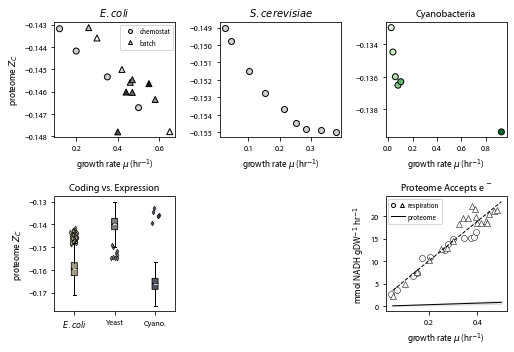

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(7.24,5))
pal = sns.color_palette()
greys = sns.color_palette('Greys')
    
plt.sca(axs[0,0])
sns.scatterplot(data=coli_schmidt_chemostat, x='growth_rate_hr', y='proteome_NOSC',
                style='dataset', markers='o', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
n_conds_batch = coli_schmidt_batch.condition.unique().size
sns.scatterplot(data=coli_schmidt_batch, x='growth_rate_hr', y='proteome_NOSC',
                hue='condition', palette=sns.color_palette('Greys', n_colors=n_conds_batch), 
                style='dataset', markers='^', edgecolor='k', color=greys[1], linewidth=1,
                legend=False)
plt.title('$E. coli$')
plt.ylabel('proteome $Z_C$')
plt.xlabel('growth rate $\mu$ (hr$^{-1}$)')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='chemostat',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4),
                   Line2D([0], [0], marker='^', color='w', label='batch',
                          markerfacecolor=greys[1], markeredgecolor='k',
                          linewidth=1, markersize=4)]
plt.gca().legend(handles=legend_elements, loc=1,
                 handletextpad=0.4, borderaxespad=0.3)

plt.sca(axs[0,1])
sns.scatterplot(data=yeast_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1)
plt.title('$S. cerevisiae$')
plt.xlabel('growth rate $\mu$ (hr$^{-1}$)')
plt.ylabel('')

plt.sca(axs[0,2])
# color by light intensity? 
n_intensities = cyano_data.red_light_intensity_uE_m_s.unique().size
sns.scatterplot(data=cyano_data, x='growth_rate_hr', y='proteome_NOSC',
                edgecolor='k', color=greys[1], linewidth=1,
                hue='red_light_intensity_uE_m_s',
                palette=sns.color_palette('Greens', n_colors=n_intensities),
                legend=False)
plt.title('Cyanobacteria')
plt.ylabel('')
plt.xlabel('growth rate $\mu$ (hr$^{-1}$)')

plt.sca(axs[1,0])
order = 'coli,yeast,PCC6803'.split(',')
labels = dict(coli='$E. coli$', yeast='Yeast', PCC6803='Cyano.')
pal = sns.color_palette('cividis_r', n_colors=len(order), desat=0.4)
for i, org in enumerate(order):
    samples = weighted_nosc_est_df[weighted_nosc_est_df.organism == org].NOSC.values
    plt.boxplot(samples, positions=[i], notch=True, showfliers=False, showmeans=False,
                patch_artist=True, boxprops=dict(facecolor=pal[i], linewidth=0.75), medianprops=dict(color=greys[1]))
    
# plot range of coli measurements
coli_vals = coli_data.proteome_NOSC.values
xs = np.zeros(coli_vals.size) + np.random.normal(0, 0.05, coli_vals.size)
plt.scatter(xs, coli_vals, marker='d', color=pal[0], edgecolors='k',
            s=12, linewidths=0.5)

# plot range of yeast measurements
yeast_vals = yeast_data.proteome_NOSC.values
xs = np.ones(yeast_vals.size) + np.random.normal(0, 0.05, yeast_vals.size)
plt.scatter(xs, yeast_vals, marker='d', color=pal[1], edgecolors='k',
            s=12, linewidths=0.5)

# plot range of cyano measurements
cyano_vals = cyano_data.proteome_NOSC.values
xs = np.ones(cyano_vals.size)*2 + np.random.normal(0, 0.05, cyano_vals.size)
plt.scatter(xs, cyano_vals, marker='d', color=pal[2], edgecolors='k',
            s=12, linewidths=0.5)

ticks = [labels[o] for o in order]
plt.xticks(np.arange(len(order)), ticks, ha='center')
plt.ylabel('proteome $Z_C$')
plt.title('Coding vs. Expression')

plt.sca(axs[1, 1])
plt.axis('off')

plt.sca(axs[1, 2])
# Growth rates u range from 0.05 (10 hrs) to 0.5 (80 min) to match data roughly
mus = np.arange(0.05, 0.51, 0.01)

# Assume proteins are produced to match dilution by growth, i.e. degradation is negligible
# as typical lifetimes are longer than generation times. This is more likely to be true
# at higher growth rates.
med_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[50.0].value
min_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[2.5].value
max_mmolC_per_gDW = mmol_prot_C_per_gDW_est_df.loc[97.5].value
print('mmol protein C / gDW')
print('median est: {0:.2f}'.format(med_mmolC_per_gDW))
print('95% CI: {0:.2f}-{1:.2f}'.format(min_mmolC_per_gDW, max_mmolC_per_gDW))

protein_C_flux_med = med_mmolC_per_gDW * mus    # mmol aa C / gDW / hr
protein_C_flux_min = min_mmolC_per_gDW * mus    # mmol aa C / gDW / hr
protein_C_flux_max = max_mmolC_per_gDW * mus    # mmol aa C / gDW / hr

min_delta_NOSC = 0.1
protein_e_flux_min = protein_C_flux_min * min_delta_NOSC
max_delta_NOSC = 0.2
protein_e_flux_max = protein_C_flux_max * max_delta_NOSC

e_per_NADH = 2
protein_NADH_flux_min = protein_e_flux_min/e_per_NADH
protein_NADH_flux_max = protein_e_flux_max/e_per_NADH
protein_NADH_flux_med = 0.15*protein_C_flux_med/e_per_NADH

m = fit_resp_NADH_consumption_df.at['slope', 'both_fit']
b = fit_resp_NADH_consumption_df.at['intercept', 'both_fit']
pred_resp_NADH_cons = m*mus + b
plt.plot(mus, pred_resp_NADH_cons, ls='--', color='k', lw=1)
plt.scatter(kayser_chemostat_df.D_per_h, kayser_chemostat_df.r_o2_mmol_NADH_g_h,
            label='$E. coli$ resp.',
            color='w', edgecolors='k', lw=0.5, marker='o')
plt.scatter(postma_chemostat_df.D_per_h, postma_chemostat_df.qO2_mmol_NADH_gDW_hr,
            label='yeast resp.', color='w', edgecolors='k', lw=0.5, marker='^')

plt.fill_between(mus, protein_NADH_flux_min, protein_NADH_flux_max,
                 color=greys[2], alpha=0.3)
l = plt.plot(mus, protein_NADH_flux_med, lw=1, color='k', zorder=10,
             label='proteome')

med_ratio = protein_NADH_flux_med/pred_resp_NADH_cons
med_pct = 100*med_ratio
print('proteome biosyn. ≈ {0:.2f} +/- {1:.2f} of respiratory NADH consumption'.format(
    med_pct.mean(), med_pct.std()))

plt.title('Proteome Accepts e$^-$')
plt.ylabel('mmol NADH gDW$^{-1}$ hr$^{-1}$')
plt.xlabel('growth rate $\mu$ (hr$^{-1}$)')

line = Line2D([0], [0], color='k', linewidth=1)
circ = Line2D([0], [0], marker='o', color='w',
              markerfacecolor='w', markeredgecolor='k',
              linewidth=1, markersize=4)
tri = Line2D([0], [0], marker='^', color='w',
             markerfacecolor='w', markeredgecolor='k',
             linewidth=1, markersize=4)

legend_elements = [(circ, tri), line]
plt.gca().legend(handles=legend_elements, labels='respiration,proteome'.split(','),
                 loc=2, handletextpad=0.4, borderaxespad=0.3,
                 handler_map={tuple: HandlerTuple(ndivide=None)})

plt.tight_layout()
plt.savefig('../output/Fig1.png', facecolor='w', dpi=300)
plt.show()

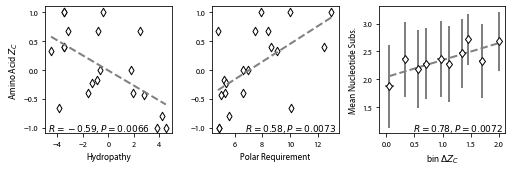

In [7]:
# Supplementary Fig X -- genetic code is expected to be conservative for Z_C.

fig, axs = plt.subplots(ncols=3, figsize=(7.22, 2.5))

plt.sca(axs[0])

mask = np.logical_and(aa_nosc_df.hydropathy.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].hydropathy
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.02, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='left', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Hydropathy')
plt.ylabel('Amino Acid $Z_C$')

plt.sca(axs[1])

mask = np.logical_and(aa_nosc_df.polar_requirement.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].polar_requirement
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Polar Requirement')

plt.sca(axs[2])
codon_subs_mean_df = pd.read_csv('../data/genetic_code/binned_codon_substitutions.csv', index_col=0)
x = codon_subs_mean_df.abs_dNOSC
y = codon_subs_mean_df.hamming_dist
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.01)
pred_y = reg.slope*pred_xs + reg.intercept

# hamming distance of codon substitution vs. change in NOSC
# note: symmetric confidence intervals are weird here. can't have > 3 subs
# todo: do non-symmetric
plt.errorbar(x, y, xerr=codon_subs_mean_df.abs_dNOSC_std, yerr=codon_subs_mean_df.hamming_dist_std, 
             marker='d', markeredgecolor='k', color='w', ls='', ecolor='grey')
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$R={0:.2f}, P={1:.2g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('bin $\Delta Z_C$')
plt.ylabel('Mean Nucleotide Subs.')

plt.tight_layout()
plt.savefig('../output/aa_NOSC_hydrophobicity.png', facecolor='w', dpi=300)
plt.show()

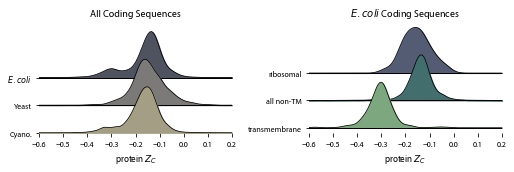

In [8]:
# Fig SX shows the range of NOSC values on proteins
fig, axs = plt.subplots(ncols=2, figsize=(7.24,2.5))

plt.sca(axs[0])
order = 'PCC6803,yeast,coli'.split(',')
labels = dict(coli='$E. coli$', yeast='Yeast', PCC6803='Cyano.')
pal = sns.color_palette('cividis_r', n_colors=len(order), desat=0.4)
plot_util.ridgeplot(long_nosc_df, 'organism', 'NOSC', overlap=0.4,
                    palette=pal, cat_order=order, labels=labels)
plt.xlabel('protein $Z_C$')
plt.title('All Coding Sequences')
plt.xlim(-0.6, 0.2)
plt.ylim(0, 2.4)
    
plt.sca(axs[1])
coli_cds = long_nosc_df[long_nosc_df.organism == 'coli']
cols2copy = 'gene_name,eC_ratio,NOSC,NC,fraction_transmembrane,tag'.split(',')

tm_prot = coli_cds[coli_cds.fraction_transmembrane > 0.3].copy()
rprot_mask = np.logical_or(coli_cds.gene_name.str.startswith('rps'), 
                           coli_cds.gene_name.str.startswith('rpl'))
r_prot = coli_cds[coli_cds.ribosomal_protein].copy()
non_tm = coli_cds[coli_cds.fraction_transmembrane < 0.1].copy()

all_prot = coli_cds.copy()
all_prot['tag'] = 'all'
r_prot['tag'] = 'ribosomal'
tm_prot['tag'] = 'transmembrane'
non_tm['tag'] = 'all non-TM'

dfs = [all_prot, r_prot, tm_prot, non_tm]
tmp_df = pd.concat([d[cols2copy] for d in dfs], ignore_index=True)

order = 'transmembrane,all non-TM,ribosomal'.split(',')
pal = sns.color_palette('viridis_r', n_colors=len(order), desat=0.4)
plot_util.ridgeplot(tmp_df, 'tag', 'NOSC', overlap=0.4,
                    palette=pal, cat_order=order)
    
plt.xlim(-0.6, 0.2)
plt.xlabel('protein $Z_C$')
plt.title('$E. coli$ Coding Sequences')

sns.despine(top=True, left=True, bottom=True, right=True)
plt.tight_layout()
plt.show()

In [9]:
all_expression_data

,b_number,dataset,strain,condition,growth_rate_hr,copies_per_cell,fg_per_cell,NOSC,NC_per,num_aas,...,organism_key,species,majority_protein_ids,fraction_transmembrane,Ce_per,Ce_total,NC_total,gene_name,sample_name,red_light_intensity_uE_m_s
0,b0167,li_2014,MG1655,MOPS complete,1.934364,206.892387,0.035165,-0.126187,4569.0,890.0,...,coli,E. coli,P27249,0.000000,-576.55,-119283.805932,945291.317842,NaN,NaN,NaN
1,b0167,li_2014,MG1655,MOPS complete without methionine,1.569390,122.291713,0.020786,-0.126187,4569.0,890.0,...,coli,E. coli,P27249,0.000000,-576.55,-70507.286956,558750.835314,NaN,NaN,NaN
2,b0167,li_2014,MG1655,MOPS minimal,0.738700,190.617683,0.032399,-0.126187,4569.0,890.0,...,coli,E. coli,P27249,0.000000,-576.55,-109900.625254,870932.194582,NaN,NaN,NaN
3,b0167,peebo_2015,BW25113,glucose_minimal,0.210000,NaN,NaN,-0.126187,4569.0,890.0,...,coli,E. coli,P27249,0.000000,-576.55,NaN,NaN,NaN,NaN,NaN
4,b0167,peebo_2015,BW25113,glucose_minimal,0.220000,4.488067,0.000763,-0.126187,4569.0,890.0,...,coli,E. coli,P27249,0.000000,-576.55,-2587.595263,20505.979980,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171964,NaN,zavrel_2019,PCC6803,photobio_1100_uE,0.930000,0.321208,NaN,-0.131433,1019.0,207.0,...,PCC6803,Synechocystis sp.,Q6ZEU6,0.000000,-133.93,-43.019377,327.310870,sll5034,NaN,1100.0
171965,NaN,zavrel_2019,PCC6803,photobio_1100_uE,0.930000,0.166779,NaN,-0.166413,1812.0,363.0,...,PCC6803,Synechocystis sp.,Q79EE4,0.000000,-301.54,-50.290401,302.202714,ggtA,NaN,1100.0
171966,NaN,zavrel_2019,PCC6803,photobio_1100_uE,0.930000,0.147759,NaN,-0.181272,2114.0,421.0,...,PCC6803,Synechocystis sp.,Q79EE5,0.000000,-383.21,-56.622726,312.362526,slr1588,NaN,1100.0
171967,NaN,zavrel_2019,PCC6803,photobio_1100_uE,0.930000,0.161586,NaN,-0.181986,1989.0,359.0,...,PCC6803,Synechocystis sp.,Q79EF1,0.264624,-361.97,-58.489292,321.394594,desB,NaN,1100.0


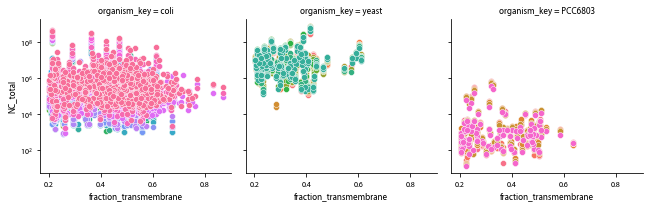

In [10]:
mask  = all_expression_data.fraction_transmembrane > 0.2
tmp = all_expression_data[mask]

g = sns.FacetGrid(tmp, col="organism_key", sharey=True, hue='growth_rate_hr')
g.map(sns.scatterplot, "fraction_transmembrane", "NC_total").set(yscale = 'log')

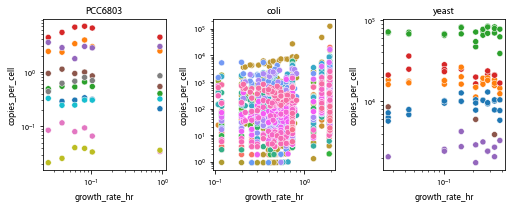

In [11]:
tmp[tmp.fraction_transmembrane > 0.3]

fig, axs = plt.subplots(ncols=3, figsize=(7.22, 3))

for idx, (gid, gdf) in enumerate(tmp[tmp.fraction_transmembrane > 0.5].groupby('organism_key')):
    plt.sca(axs[idx])
    plt.yscale('log')
    plt.xscale('log')
    sns.scatterplot(data=gdf, x='growth_rate_hr', y='copies_per_cell', hue='majority_protein_ids', legend=False)
    plt.title(gid)
    
plt.tight_layout()
plt.show()
#g = sns.FacetGrid(tmp, col="organism_key", row='majority_protein_ids', sharey=True)
#g.map(sns.scatterplot, "growth_rate_hr", "copies_per_cell").set(yscale = 'log')